In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForMaskedLM, AutoModelForCausalLM, AutoModelForSeq2SeqLM, AutoModel
from enum import Enum
import torch
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Union


c:\Users\pramo\anaconda3\envs\PromptRiddler\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ModelTypes(str, Enum):
  
  ENCODER = "ENCODER"
  DECODER = "DECODER"
  ENCODER_DECODER = "ENCODER_DECODER"


In [3]:
def get_model_and_tokenizer(model_name: str, model_type: str) -> Tuple[AutoTokenizer, Union[AutoModelForMaskedLM, AutoModelForCausalLM, AutoModelForSeq2SeqLM]]:
  """
  This function loads the model and tokenizer from the huggingface library.
  @param model_name: name of the model to be loaded
  @param model_type: type of the model to be loaded i.e. encoder, decoder, encoder-decoder
  """
  if model_type == ModelTypes.ENCODER:
    model = AutoModelForMaskedLM.from_pretrained(model_name)
  elif model_type == ModelTypes.DECODER:
    model = AutoModelForCausalLM.from_pretrained(model_name)
  elif model_type == ModelTypes.ENCODER_DECODER:
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
  else:
    raise ValueError("Invalid model type.")
  model = model.eval()
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  
  # Set padding side to the left for decoder models
  if model_type != ModelTypes.ENCODER:
    tokenizer.padding_side = "left"
  
  # Add pad token if not present
  if tokenizer.pad_token is None:
    # tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    # model.resize_token_embeddings(len(tokenizer))
    tokenizer.pad_token = tokenizer.eos_token
  
  return tokenizer, model

In [4]:
def tokenize(tokenizer: AutoTokenizer, 
    sample_text: Union[str, List[str]],
    model_type: str,
    ) -> Tuple[Dict[str, torch.Tensor], List[List[str]], List[int], List[int]]:
    """
    This function tokenizes the input text using the tokenizer provided.
    Args:
        tokenizer (AutoTokenizer): The tokenizer to be used for tokenization
        sample_text (Union[str, List[str]]): The documents to be tokenized

    Returns:
        Tuple[Dict[str, torch.Tensor], List[List[str]], List[int]]: The tokenized input, tokens, the indices of the first non-pad token, and the indices of the first pad token
    """
    
    # Add space before and after mask token for encoder models
    if model_type == ModelTypes.ENCODER:
      if isinstance(sample_text, str):
        sample_text += " " + (tokenizer.mask_token)
      else:
        sample_text = [s + " " + (tokenizer.mask_token) for s in sample_text]
    if isinstance(sample_text, str):
        # If sample_text is a string, tokenize it as a single text sequence
        inputs = tokenizer(sample_text, return_tensors="pt", padding=True)
        tokens = [tokenizer.convert_ids_to_tokens([token_id.item()])[0] for token_id in inputs.input_ids[0]]
    elif isinstance(sample_text, list):
        # If sample_text is a list, tokenize each element as a separate text sequence
        inputs = tokenizer(sample_text, return_tensors="pt", padding=True, truncation=True)
        tokens = [[tokenizer.convert_ids_to_tokens([token_id.item()])[0] for token_id in input_ids] for input_ids in inputs.input_ids]
    else:
        raise ValueError("sample_text must be a string or a list of strings")
    non_pad_token_start_idx = [inputs.attention_mask[i].tolist().index(1) for i in range(len(inputs.attention_mask))]
    # Get index where padding starts
    padding_start_idx = []
    for i in range(len(inputs.attention_mask)):
      try:
        padding_start_idx.append(inputs.attention_mask[i].tolist().index(0))
      except ValueError:
        padding_start_idx.append(len(inputs.attention_mask[i].tolist()))
        
    print(f"Tokens : {tokens}")
    return inputs, tokens, non_pad_token_start_idx, padding_start_idx

In [5]:
def get_model_predictions_and_attention(inputs: Dict[str, torch.Tensor], model: AutoModel, tokenizer:AutoTokenizer, model_type: str) -> List[torch.Tensor]:
  """This function generates the predictions and attention weights for the given model and input.

  Args:
      inputs (Dict[str, torch.Tensor]): The input to the model
      model (AutoModel): The model to be used for prediction
      tokenizer (AutoTokenizer): The tokenizer used for tokenization
      model_type (str): The type of model to be used
      
  Raises:
      ValueError: If the model type is not supported

  Returns:
      List[torch.Tensor]: The attention weights for the given model and input
      Attention weights shape: [num_layers, batch_size, num_heads, num_tokens, num_tokens]
  """
  
  with torch.no_grad():
    if model_type == ModelTypes.ENCODER:
      output = model(**inputs, output_attentions=True)
      # Get the index of the mask token acroos each document in the batch
      mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
      predicted_token_ids = [output.logits[i, mask_token_index[i]].argmax() for i in range(len(output.logits))]
      print(f"Predictions for masked tokens are {tokenizer.batch_decode(predicted_token_ids)}")
      attention_weights = output.attentions
    
    elif model_type == ModelTypes.DECODER:
      output = model.generate(**inputs, output_attentions=True, return_dict_in_generate=True, max_length = len(inputs["input_ids"][0])+1, output_scores=True)
      # Get the last token of the generated sequence
      output_strings = tokenizer.batch_decode([output.sequences[i][-1] for i in range(len(output.sequences))],skip_special_tokens=False)
      print(f"Completion's are {output_strings}")
      # Get the attention weights for only the generated token excluding prompt tokens
      attention_weights = output.attentions[-1]
    
    elif model_type == ModelTypes.ENCODER_DECODER:
      output = model.generate(**inputs, output_attentions=True, return_dict_in_generate=True, max_length = len(s2s_inputs["input_ids"][0])+1, do_sample=False) 
      print(f"Completion is {tokenizer.decode(output.sequences[0],skip_special_tokens=False)}")
      attention_weights = output.encoder_attentions
    
    else:
      raise ValueError(f"{model_type} is not supported")
  
  print(f"Number of layers is {len(output.attentions[0])}")
  print(attention_weights[0].shape)
  # Average attention scores across heads
  attention_weights = [torch.mean(attention_weights[i],axis=1) for i in range(len(attention_weights))]
  # Shape [num_layers,  batch_size, num_tokens, num_tokens]
  return attention_weights

In [16]:
def get_special_token_indices(token_ids:torch.Tensor, tokenizer:AutoTokenizer) -> Tuple[List[np.ndarray], bool]:
    """
    This function returns the indices of the special tokens in the token IDs tensor.

    Args:
        token_ids (torch.Tensor): The token IDs tensor
        tokenizer (AutoTokenizer): The tokenizer used for tokenization

    Returns:
        Tuple[List[np.ndarray], bool]: The indices of the special tokens in the token IDs tensor 
        and a boolean indicating if any special tokens were found
    """
    # Get the special token IDs for the tokenizer
    special_token_ids = tokenizer.all_special_ids
    print(f"Special token ids are {special_token_ids}")
    # Remove the pad token ID from the list (if there is one)
    try:
        special_token_ids.remove(tokenizer.pad_token_id)
        special_token_ids.remove(tokenizer.mask_token_id)
    except ValueError:
        pass
    # Get the indices of the special tokens in the token IDs tensor
    if special_token_ids:
        special_token_indices = [torch.where(token_ids == i)[1].numpy() for i in special_token_ids]
        # Remove empty tensors (i.e. no special tokens found)
        special_token_indices = [a for a in special_token_indices if a.size > 0]
        found_special_tokens = True if special_token_indices else False
    else:
        special_token_indices = []
        found_special_tokens = False
    return special_token_indices, found_special_tokens

In [7]:
def get_highest_attention_index(attention_weights: List[torch.Tensor], tokens: List[List[str]]) -> Tuple[Dict[str, int], Dict[int, int]]:
    """
    This function returns a dictionary of the token indices with the highest attention score for each layer.
    The key is the token id and the value is the frequency of the token id being the most attended to token.
    """
    highest_attention_token = defaultdict(int)
    highest_attention_token_indices = defaultdict(int)
    for layer in range(len(attention_weights)):
        for batch_ind in range(len(attention_weights[layer])):
            # Get the attention scores for the current layer in the batch ignoring the padding tokens
            layer_attention = attention_weights[layer][batch_ind, non_pad_start_idx[batch_ind]:,]
            # Get the token indices with the highest attention scores
            highest_attention_indices = layer_attention.argmax(dim=1)
            # Map token index to token
            for token_id in highest_attention_indices:
                highest_attention_token[tokens[batch_ind][token_id.item()]] += 1
                highest_attention_token_indices[token_id.item()- non_pad_start_idx[batch_ind]] += 1

    # Keep only the top 10 most attended to tokens
    highest_attention_token = dict(sorted(highest_attention_token.items(), key=lambda item: item[1], reverse=True)[:10])
    highest_attention_token_indices = dict(sorted(highest_attention_token_indices.items(), key=lambda item: item[1], reverse=True)[:10])
    return highest_attention_token, highest_attention_token_indices

In [8]:
sample_text = [
    # Random short text
    "Z Just woke up! Time to",
    # Tweet
    """Z UPDATE: We have spent the past month “fine-tuning” our approach for Closed Book QA (CBQA, no access to external knowledge) 
    w/ T5 and now our appendix is overflowing with interesting results and new SoTAs on open""",
    # Reddit post
    """Z Tim Hardaway Jr had a great game tonight. It got me thinking about father-son duos in the NBA. 
    I was in college at the same time as MJ's kids and I always found it interesting how they played but never made it in the league. 
    I wanted to check out father son pairings. What seems to be the case is the children of most STAR""",
    # Nature article
    """Z psychedelic drugs have been undergoing a major makeover in psychiatry, earning mainstream acceptance that has eluded them for decades. 
    In 2019, a variant of ketamine — an animal tranquillizer well known as a club drug — was approved by the US Food and Drug Administration (FDA) 
    for treating post-traumatic stress disorder (PTSD). In May, Oregon opened its first treatment centre for administering 
    psilocybin — the hallucinogenic compound found in magic mushrooms — following the state’s decision to legalize it (psilocybin remains illegal at the federal level). 
    And, after decades of effort we""",
    # Short story
    """Z The night came slowly, softly, as I lay out there under the maple tree. It came creeping, creeping stealthily out of the 
    valley, thinking I did not notice. And the outlines of trees and foliage nearby blended in one black mass and 
    the night came stealing out from them, too, and from the east and west, until the only light was in the sky, 
    filtering through the maple leaves and a star looking down through every cranny.
    The night is solemn and it means mystery.
    Human shapes flitted by like intangible things. Some stole up like little mice to peep at me. I did not mind. 
    My whole being was abandoned to the soothing and penetrating""",
    # Technical Docs
    """Z How FSDP works In DistributedDataParallel, (DDP) training, each process/ worker owns a replica of the model 
    and processes a batch of data, finally it uses all-reduce to sum up gradients over different workers. 
    In DDP the model weights and optimizer states are replicated across all workers. FSDP is a type of data parallelism that shards model parameters, 
    optimizer states and gradients across DDP ranks.
    When training with FSDP, the GPU memory footprint is smaller than when training with DDP across all workers. 
    This makes the training of some very large models feasible by allowing larger models or batch sizes to fit on device. 
    This comes with the cost of increased communication volume. The communication overhead is reduced by nternal optimizations like 
    overlapping communication and computation. At a high level FSDP works as follow:
    In constructor
    Shard model parameters and each rank only keeps its own shard
    In forward path
    Run all_gather to collect all""",
    # News
    """Z Stocks soared on Thursday as investors bet the Federal Reserve is close to wrapping up its 
    rate-hiking campaign and assessed a fresh stream of corporate results.
    The tech-heavy Nasdaq (^IXIC) and the S&P 500 (^GSPC) closed about 1.8% and 1.9% higher, respectively, 
    while the Dow Jones Industrial Average (^DJI) gained roughly 1.7%, or more than 500 points.
    All three major gauges ended Wednesday with strong gains after the Fed held interest rates steady at their highest range 
    in 22 years. The market's overall takeaway from Chair Jerome Powell's comments on the decision is that the US central 
    bank will stick with keeping rates unchanged in December.
    Read more: What the Fed rate-hike pause means for bank accounts, CDs, loans, and credit cards
    Traders are now pricing in an 85% chance there will be no more Fed hikes this year, compared with a 59% 
    probability the day before its policymakers' meeting, according to the CME FedWatch Tool.
    Attention is now turning to earnings season, with Apple's (AAPL) quarterly report due after hours as the highlight in a packed 
    Thursday. Top of mind will be what its results show about the iPhone situation in China and global consumer 
    spending, after a mixed bag of reports from US tech giants so far.
    Meanwhile, Starbucks stock (SBUX) popped nearly 10% after the coffee chain beat estimates for revenue and earnings. 
    Shopify (SHOP) said it returned to a profit in the third quarter as it adopted AI, and its shares jumped more than""",
    # Wikipedia article
    """Z Taylor Alison Swift (born December 13, 1989) is an American singer-songwriter. Recognized for her songwriting, musical 
    versatility, artistic reinventions, and influence on the music industry, she is a prominent cultural figure of the 21st century.
    Swift began professional songwriting at age 14 and signed with Big Machine Records in 2005 to become a country singer. 
    She released six studio albums under the label, four of them to country radio, starting with her 2006 self-titled album. 
    Her next, Fearless (2008), explored country pop, and its singles "Love Story" and "You Belong with Me" catapulted her to prominence. 
    Speak Now (2010) infused rock influences, while Red (2012) experimented with electronic elements 
    and featured Swift's first Billboard Hot 100 number-one song, "We Are Never Ever Getting Back Together". 
    She departed from her country image with 1989 (2014), a synth-pop album supported by the chart-topping songs "Shake It Off", 
    "Blank Space", and "Bad Blood". Media scrutiny inspired the hip-hop-flavored Reputation (2017) 
    and its number-one single "Look What You Made Me Do".
    Swift shifted to Republic Records in 2018. She released the pop album Lover (2019) and autobiographical documentary 
    Miss Americana (2020), embraced indie folk and alternative rock on 2020 albums Folklore and Evermore, explored chill-out styles on Midnights (2022), and released 
    four re-recorded albums as Taylor's Version following a dispute with Big Machine. The albums and their 
    number-one songs "Cruel Summer", "Cardigan", "Willow", "Anti-Hero" and "All Too Well" broke various  records.
    In 2023, Swift embarked on the Eras Tour and released its accompanying concert film. She has directed music videos 
    and films such as All Too Well: The Short Film (2021). Having sold over 200 million records globally, Swift is one of the best-selling musicians, 
    the most-streamed woman on Spotify, the first billionaire with music as the main source of"""
    ]

instruction_sample_text = f"Please answer the following question. {sample_text}"

In [10]:
#model_name = "facebook/opt-125m"
model_name = "roberta-large"
model_type = ModelTypes.ENCODER
tokenizer, model = get_model_and_tokenizer(model_name, model_type)

In [11]:
a = torch.tensor([[1,2,3],[4,5,6]])
torch.take(a, torch.tensor([0,1]))

tensor([1, 2])

In [12]:
inputs, tokens, non_pad_start_idx, pad_start_idx = tokenize(tokenizer, sample_text, model_type)
attention_weights = get_model_predictions_and_attention(inputs, model, tokenizer, model_type)

Tokens : [['<s>', 'Z', 'ĠJust', 'Ġwoke', 'Ġup', '!', 'ĠTime', 'Ġto', '<mask>', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pa

In [13]:
len(tokens)

8

In [14]:
non_pad_start_idx

[0, 0, 0, 0, 0, 0, 0, 0]

In [118]:
tokenizer(["Hi","What's up?"])

{'input_ids': [[17250], [2061, 338, 510, 30]], 'attention_mask': [[1], [1, 1, 1, 1]]}

In [17]:
special_tokens, found_special_tokens = get_special_token_indices(inputs.input_ids, tokenizer)
if len(special_tokens) == 0:
  special_tokens = [non_pad_start_idx]
special_tokens

Special token ids are [0, 2, 3, 1, 50264]


[array([0, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
 array([  9,  62,  88, 147, 166, 248, 391, 506], dtype=int64)]

In [168]:
a = torch.tensor([[[1,4],[50,23],[6,4]],[[2,68],[3,78],[13,4]]])
torch.argmax(a,axis=-1)

tensor([[1, 0, 0],
        [1, 1, 0]])

In [268]:
highest_attention_token, highest_attention_positions = get_highest_attention_index(attention_weights, tokens)
highest_attention_positions

{0: 14847,
 77: 26,
 29: 25,
 40: 24,
 92: 24,
 19: 22,
 23: 22,
 36: 22,
 55: 22,
 28: 21}

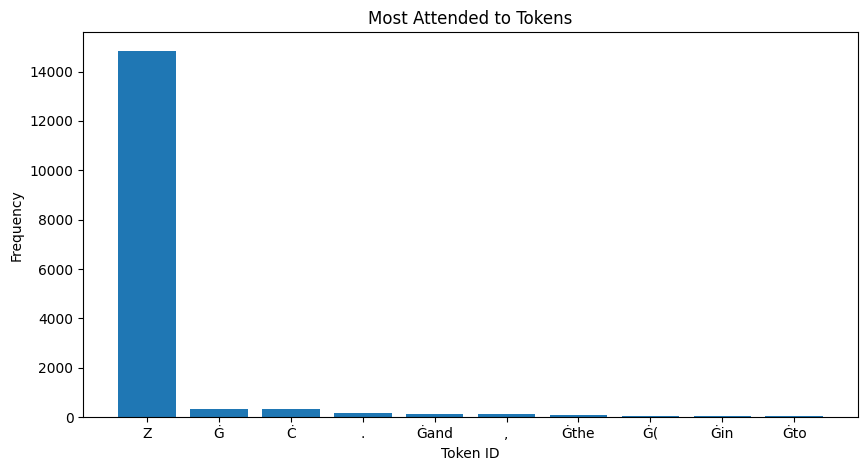

In [248]:
# Plot the histogram of the most attended to tokens
plt.figure(figsize=(10, 5))
plt.bar(highest_attention.keys(), highest_attention.values())
plt.xlabel("Token ID")
plt.ylabel("Frequency")
plt.title("Most Attended to Tokens")
plt.show()


In [121]:
attention_weights[-1][3][non_pad_start_idx[3]:,non_pad_start_idx[3]]

tensor([1.0000, 0.8215, 0.7493, 0.6819, 0.6520, 0.7529, 0.5414, 0.8282, 0.8648,
        0.5623, 0.6265, 0.5785, 0.5600, 0.6626, 0.8600, 0.5787, 0.6466, 0.7393,
        0.7001, 0.5851, 0.5842, 0.5582, 0.6437, 0.5485, 0.4464, 0.4393, 0.4394,
        0.5697, 0.5599, 0.5679, 0.4824, 0.5755, 0.4596, 0.5313, 0.5963, 0.4921,
        0.5252, 0.5433, 0.5486, 0.5112, 0.3336])

In [249]:
# 32 is for the number of layers
special_token_attention_scores = defaultdict(lambda: [[] for _ in range(32)])

In [250]:
# Get the attention weights for the special tokens across all layers, average scores across all tokens
for layer_index in range(len(attention_weights)):
    for batch_ind in range(len(attention_weights[layer_index])):
        for special_token in special_tokens:
            special_token_index = special_token[batch_ind]
            if found_special_tokens:
                token_name = tokens[batch_ind][special_token_index]
            else:
                token_name = "[POSITION_0]"
            special_token_attention_scores[token_name][layer_index]\
            .append(torch.mean(attention_weights[layer_index][batch_ind, non_pad_start_idx[batch_ind]:, special_token_index]).item())


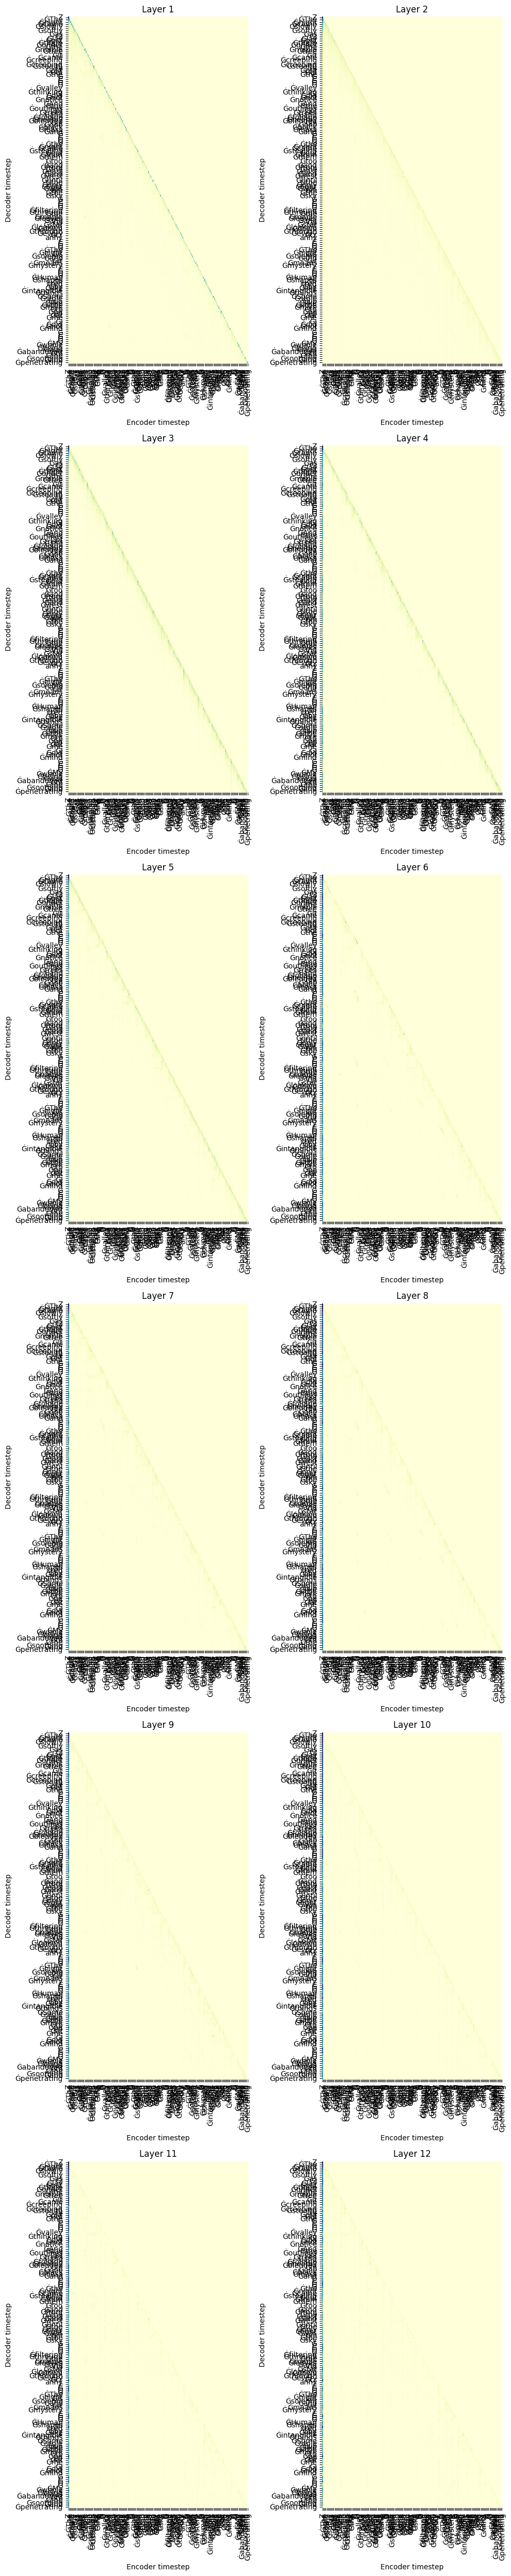

In [251]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming you have an attention tensor called `attention_tensor` of shape [12, 8, 8]
# and an array called `tokens` that maps to the 8 tokens for which self-attention scores were calculated

# Set up the plot
fig, axs = plt.subplots(nrows=len(attention_weights)//2, ncols=2, figsize=(10, 50))
batch_index = 1
if model_type == ModelTypes.ENCODER:
  token_offset = pad_start_idx[batch_index]
else:
  token_offset = non_pad_start_idx[batch_index]
# Plot the attention weights for each layer
for layer_num, ax in enumerate(axs.flat):
    if model_type == ModelTypes.ENCODER:
      tick_labels = tokens[batch_index][:token_offset]
      attention_weights_to_plot = attention_weights[layer_num][batch_index][:token_offset,:token_offset]
    else:
      tick_labels = tokens[batch_index][token_offset:]
      attention_weights_to_plot = attention_weights[layer_num][batch_index][token_offset:,token_offset:]
    sns.heatmap(attention_weights_to_plot, ax=ax, cmap='YlGnBu', cbar_kws={'label': 'Attention weight', 'orientation': 'horizontal', 'fraction': 0.046, 'pad': 0.04}, cbar=False, xticklabels=tick_labels, yticklabels=tick_labels)
    ax.set_title(f'Layer {layer_num+1}')
    ax.set_xlabel('Encoder timestep')
    ax.set_ylabel('Decoder timestep')

# Adjust the size of the subplots
plt.tight_layout()

# Show the plot
plt.show()

In [252]:
import matplotlib.pyplot as plt

def plot_attention_histograms(special_token_attention_scores):
    # Loop over each key in the special_token_attention_scores dictionary
    for key in special_token_attention_scores.keys():
        # Get the attention scores for the current key
        attention_scores = special_token_attention_scores[key]
        
        # Loop over each layer in the attention_scores list
        for i, layer_scores in enumerate(attention_scores):
            if layer_scores:
                # Plot a histogram of the attention scores for the current layer
                plt.hist(layer_scores, bins=5)
                plt.title(f'Attention scores for "{key}" in layer {i+1}')
                plt.xlabel('Attention score')
                plt.ylabel('Frequency')
                plt.show()

In [253]:
special_token_attention_scores

defaultdict(<function __main__.<lambda>()>,
            {'[POSITION_0]': [[0.38788342475891113,
               0.07688459753990173,
               0.0608951710164547,
               0.03546854108572006,
               0.0312807522714138,
               0.023727456107735634,
               0.015509423799812794,
               0.011739497072994709],
              [0.5762087106704712,
               0.18588407337665558,
               0.16009987890720367,
               0.11944856494665146,
               0.10575076192617416,
               0.07601305842399597,
               0.05178394541144371,
               0.04062903672456741],
              [0.5690228343009949,
               0.2071201056241989,
               0.19950857758522034,
               0.18734286725521088,
               0.18150459229946136,
               0.17183424532413483,
               0.14976470172405243,
               0.13979609310626984],
              [0.6762649416923523,
               0.42419955134391785,
    

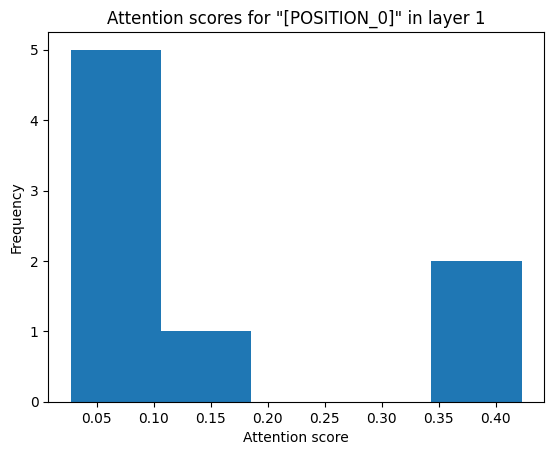

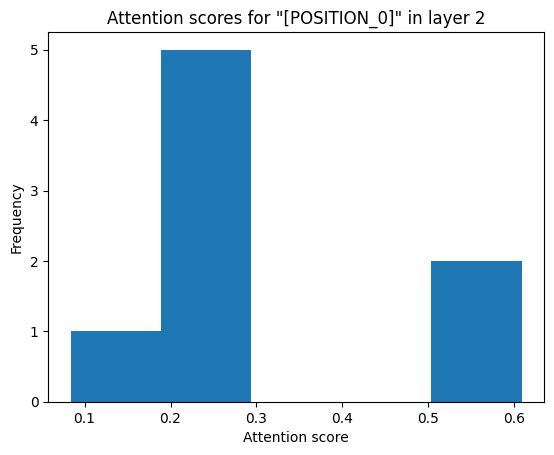

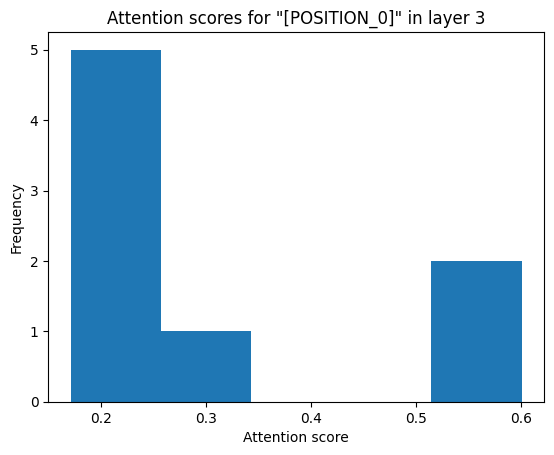

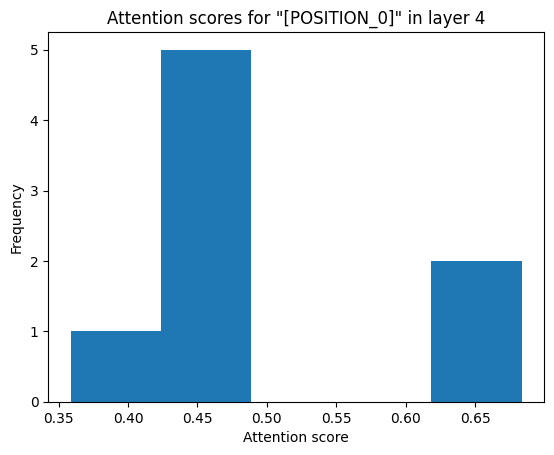

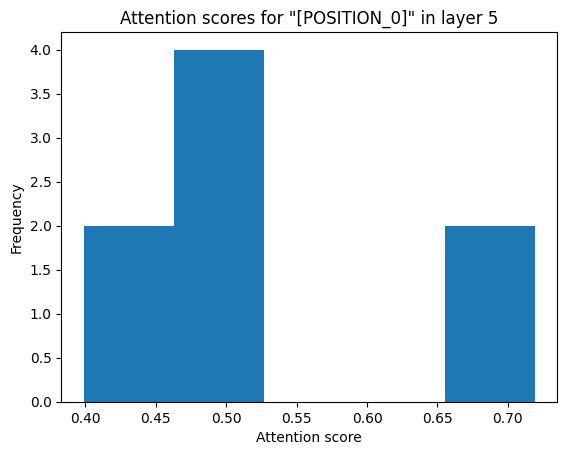

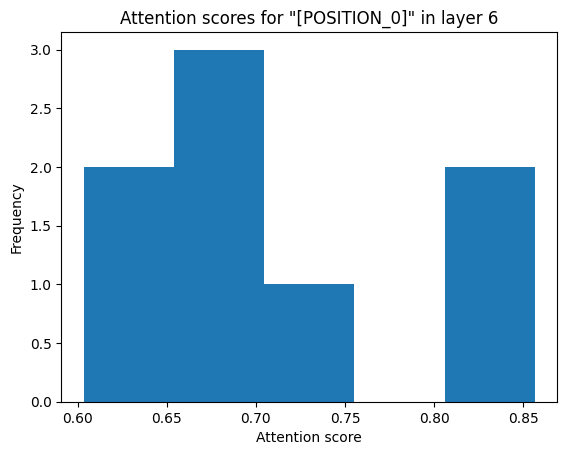

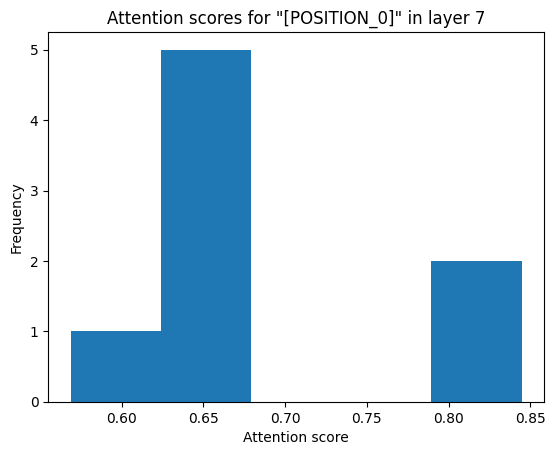

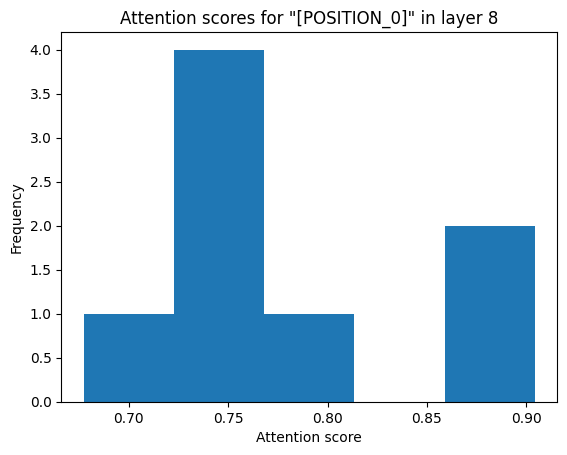

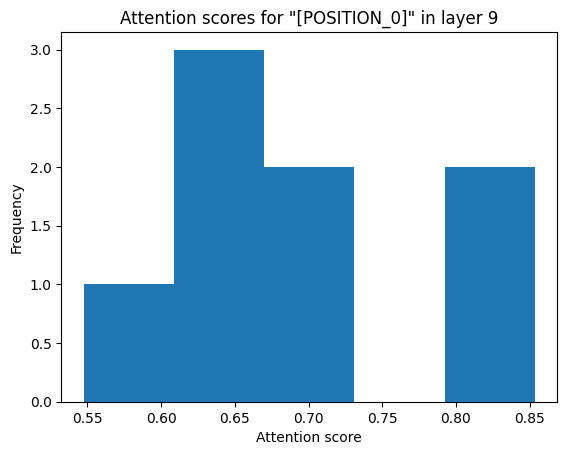

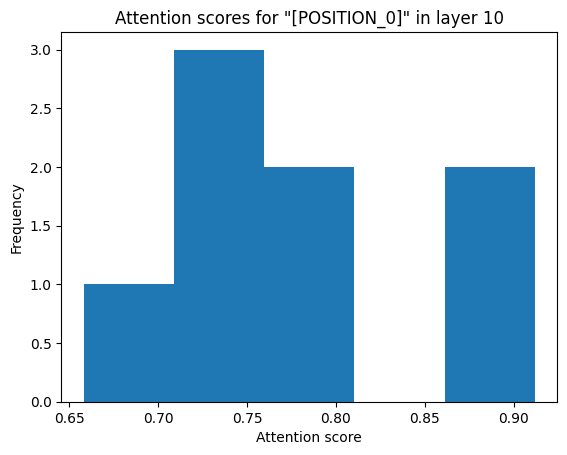

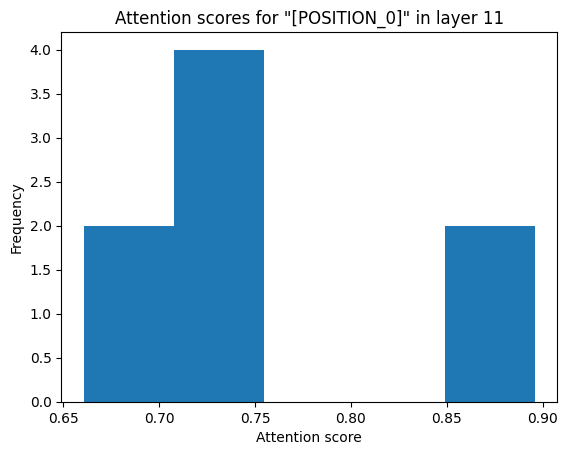

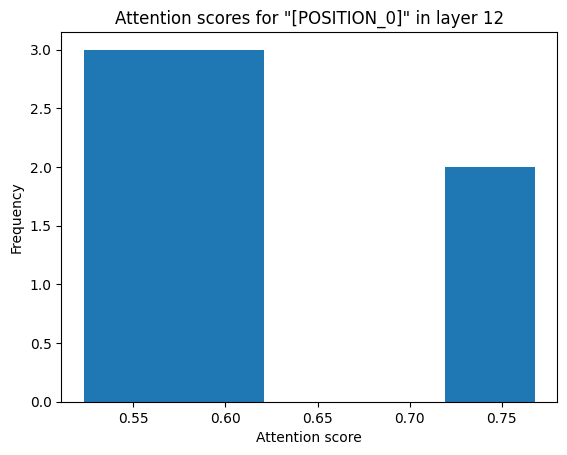

In [130]:
# Assuming you have a dictionary called `special_token_attention_scores`

plot_attention_histograms(special_token_attention_scores)